# Do students describe professors differently based on gender?

_Note: You can consult the solution of this live training in the file browser as `notebook-solution.ipynb`_

Language plays a crucial role in shaping our perceptions and attitudes towards gender in the workplace, in classrooms, and personal relationships. Studies have shown that gender bias in language can have a significant impact on the way people are perceived and treated. 

For example, research has found that job advertisements that use masculine-coded language tend to attract more male applicants, while those that use feminine-coded language tend to attract more female applicants. Similarly, gendered language can perpetuate differences in the classroom.

In this project, we'll using scraped student reviews from [ratemyprofessors.com](https://ratemyprofessors.com) to identify differences in language commonly used for male vs. female professors, and explore subtleties in how language in the classroom can be gendered.

This excellent [tool](https://benschmidt.org/profGender/#%7B%22database%22%3A%22RMP%22%2C%22plotType%22%3A%22pointchart%22%2C%22method%22%3A%22return_json%22%2C%22search_limits%22%3A%7B%22word%22%3A%5B%22aggressive%22%5D%2C%22department__id%22%3A%7B%22%24lte%22%3A25%7D%2C%22rHelpful%22%3A%5B1%2C2%5D%2C%22rClarity%22%3A%5B1%2C2%5D%7D%2C%22aesthetic%22%3A%7B%22x%22%3A%22WordsPerMillion%22%2C%22y%22%3A%22department%22%2C%22color%22%3A%22gender%22%7D%2C%22counttype%22%3A%5B%22WordsPerMillion%22%5D%2C%22groups%22%3A%5B%22department%22%2C%22gender%22%5D%2C%22testGroup%22%3A%22C%22%7D) created by Ben Schmidt allows us to enter the words and phrases that we find in our analysis and explore them in more depth. We'll do this at the end.

Catalyst also does some incredible work on [decoding](https://www.catalyst.org/2015/05/07/can-you-spot-the-gender-bias-in-this-job-description/) gendered language.

# 1. Scraping the web for reviews of professors

Text data––especially gendered text data, is hard to come by. Web scraping can be a helpful data collection tool when datasets are unable for this kind of work. We can write web scrapers to compile datasets on job descriptions, freelancer reviews, and, as in our use-case, professor reviews by students.

[ratemyprofessors.com](https://www.ratemyprofessors.com/professor?tid=589) provides a wonderful combination of qualitative and quantitative metrics that we can analyze.

Although the data on their websites is not labeled by gender, we'll use pronouns used by students to label professors "Male" or "Female". Of course, this approach is not perfect, as it relies on the _students'_ use of pronouns. Professors with non-binary pronouns will also be under-represented in the data, since very few reviews will have them, and so it's not trivial to write an algorithm to detect them. These are definitely important questions in the world of gender analysis though, so we encourage you to pick them up as extensions of this project!

### Task 1a. What relevant packages do we need for web scraping and reading in data?

In [3]:
# Used to open urls
import requests

# Used to parse html
from lxml import etree

# Used to pause code intermittently so that our scraper is not blocked
import time

# For data manipulation and analysis
import pandas as pd

# To access our data filenames so we can read them
import os

### Task 1b. Which professors will we be looking at?

The `web_scraping.ipynb` notebook provided in this workspace provides some code using selenium that was used to find urls from [ratemyprofessors.com](https://ratemyprofessors.com) that we'll be scraping in this notebook.

Whilst the specific selenium code used to generate this list of URLs is beyond what we can cover today, we encourage you to explore this code to understand how we generated this list of professors!

For now, we'll open the file `profs_888.txt` and read each professor's url in a new line, and save this variable as `profs`.

In [4]:
with open(r'profs_1244.txt', 'r') as f:
    profs = [x.strip() for x in f.readlines()]

In [5]:
profs[0]

'https://www.ratemyprofessors.com/professor?tid=398'

### Task 1c. How can we use urls to scrape relevant data about professors?

Each professor has an overall rating that looks like this
<img src="img/overall_rating_example.png"  width="400">

and a series of reviews that look like this
![Review example](img/review_example.png)

The code below can be used to iterate through all or part of the list of urls in `profs`, and scrape them for qualtiative and quantitative data. **You won't need to run through this whole list though, because the `data/` folder already contains the reviews of several professors that we have scraped for you!**

- The overall rating for the professor
- All the individual reviews written by students about the professor
- The "emotion" corresponding to each individual review: `😎 AWESOME`, `😐 AVERAGE`, or `😖 AWFUL`
- A numerical "quality" rating corresponding to each individual review

We won't be using the "difficulty" ratings shown here.

In [6]:
from io import StringIO

In [7]:
import numpy as np

In [8]:
# USE ONLY ONE OF THE FOLLOWING FOR STATWEMENTS

# 1. Sample code to loop through the whole list of professors    
# for s in (range(40, len(profs),10)):

# 2. Sample code to loop through the first 10 professors
for s in range(0,10,10):

    texts = [] # Initialzie an empty array
    print((s, s+10)) # Iterate through 10 professors at a time
    
    for url in profs[s:s+10]: # Iterate through this block
        time.sleep(3) # To prevent sending too many requests at once
        r = requests.get(url) # Open URL
        htmlparser = etree.HTMLParser() # Instantiate a parser to parse HTML
        tree = etree.parse(StringIO(r.text), htmlparser) # Parse HTML returned by the url
        
        text = tree.xpath('//*[@id="ratingsList"]/li[*]/div/div/div[3]/div[3]/text()') # Extract reviews
        ratings = tree.xpath('//*[@id="root"]/div/div/div[3]/div[2]/div[1]/div[1]/div[1]/div/div[1]') # Extract ratings
        emotion = tree.xpath('//*[@id="ratingsList"]/li[*]/div/div/div[1]/div[1]/div[2]/text()') # Extract emotion
        quality = tree.xpath('//*[@id="ratingsList"]/li[*]/div/div/div[2]/div[1]/div/div[2]') # Extract quality
        texts.append((url,
                      text,
                      [i.text for i in ratings][0],
                      emotion,
                      [i.text for i in quality],
                     )) # Append metrics to empty list

    print() # Print new line for readability
    df = pd.DataFrame(texts, columns = ['url', 'review', 'rating', 'emtion', 'quality'])
    df.to_csv(f'df_{s}_to_{s+10}.csv') # Write result to df in blocks of 10 professors at a time
    time.sleep(3) # Pause to prevent sending too many requests at once

(0, 10)



# 2. Reading pre-scraped data

### Task 2a. How can we read a directory of scraped professor reviews and concatenate them?

Since we have already scraped reviews from several professors for you, let's begin by concatenating all the files in the `data` folder provided. These have already been scraped for you.

Since `review`, `emotion` and `quality` are lists but were recorded in string form, we'll apply `eval()` to them to turn them back from a string into a list.

In [9]:
from glob import glob

In [10]:
df = pd.concat([pd.read_csv(x, index_col=0) for x in glob('data/*.csv')]).reset_index(drop = True)
df['review'] = df['review'].apply(lambda x: eval(x))
df['emotion'] = df['emotion'].apply(lambda x: eval(x))
df['quality'] = df['quality'].apply(lambda x: eval(x))

### Task 2b. What does the final shape of our DataFrame look like?

Browse the `df` below to familiarize yourself with the dataset we'll be working with. The DataFrame contains one row for each professor, containing:
- Their url
- All the raw text reviews for that professor
- Their overall rating
- All the emotion labels associated with reviews of that professor
- All quality ratings assigned to that professor

In [11]:
df

,prof,review,rating,emotion,quality
0,https://www.ratemyprofessors.com/professor?tid...,[Good experience for a class online. It was un...,3.1,"[awesome, awful, awful, awful, average, awful,...","[4.0, 2.0, 1.0, 1.0, 3.0, 2.5, 1.5, 2.0, 2.0, ..."
1,https://www.ratemyprofessors.com/professor?tid...,[I used to like Geography before I took Ali. G...,3.1,"[awful, average, awful, awful, awful, average,...","[2.5, 3.5, 2.5, 2.5, 2.0, 3.0, 4.5, 4.5, 4.0, ..."
2,https://www.ratemyprofessors.com/professor?tid...,[She was a good professor. It was a pass/fail ...,3.9,"[awesome, awesome, awesome, awesome, awesome, ...","[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 1.5, 5.0, 1.5, ..."
3,https://www.ratemyprofessors.com/professor?tid...,[Writing 104 with someone else is the class yo...,2.0,"[awful, awesome, awful, awful, awful, awesome,...","[1.0, 4.0, 1.0, 1.0, 1.5, 4.0, 2.0, 2.0, 4.0, ..."
4,https://www.ratemyprofessors.com/professor?tid...,"[Honestly, this guy is great. I took him a few...",4.1,"[awesome, average, awesome, awesome, awesome, ...","[5.0, 3.0, 4.5, 5.0, 4.0, 5.0, 4.5, 2.0, 1.0, ..."
...,...,...,...,...,...
575,https://www.ratemyprofessors.com/professor?tid...,[This is one of the better profs at CSUSB. I s...,2.6,"[average, awful, awesome, awful, awesome, awfu...","[3.0, 1.0, 4.0, 1.0, 4.0, 1.0, 1.0, 4.0, 3.0, ..."
576,https://www.ratemyprofessors.com/professor?tid...,[His class is extremely hard. I usually make v...,2.8,"[awful, awful, awful, awful, awful, awesome, a...","[1.0, 1.0, 1.0, 2.0, 1.5, 4.5, 2.0, 3.0, 5.0, ..."
577,https://www.ratemyprofessors.com/professor?tid...,"[(Chem 8) Prides himself on being a ""fair"" pro...",3.1,"[awful, awesome, average, awesome, average, aw...","[1.0, 5.0, 3.5, 4.0, 3.0, 2.5, 3.0, 3.5, 4.0, ..."
578,https://www.ratemyprofessors.com/professor?tid...,[I had him back in 1980! Some things never ch...,3.6,"[average, awesome, awful, awesome, awesome, av...","[3.0, 4.0, 2.5, 4.0, 5.0, 3.5, 2.5, 4.5, 4.5, ..."


# 3. Text Analysis

## 3a. What additional package imports are required for data visualization and NLP?

In [42]:
import numpy as np # For manipulating matrices during NLP

import nltk # Natural language toolkit
from nltk.tokenize import word_tokenize # Used for breaking up strings of text (e.g. sentences) into words
from nltk.stem.porter import PorterStemmer # Used to return the dictionary base of a word
from nltk.tokenize import WhitespaceTokenizer # Used for breaking up strings of text (e.g. sentences) into words based on white space

nltk.download('punkt')

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer # Used to count the occurences of words and phrases
from sklearn.feature_extraction import text as sktext# Using to extrat features from text

# For plotting
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style='white')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/kantundpeterpan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 3b. How can we assign gender labels to professors?

Let's write a custom function that assigns a gender label to professors based on the pronouns most commontly used for him. Specifically:
- If any of `['she', 'her', 'herself', 'shes']` occur more than 5 times across all reviews for that professor, we label the professor "F".
- If any of `['him', 'he', 'his', 'himself']` occur more than 5 times across all reviews for that professor, we label the professor "F".

In [13]:
from collections import Counter

In [14]:
def assign_pronoun(review_list):
    
    she_ps = ['she', 'her', 'herself', 'shes']
    he_ps = ['him', 'he', 'his', 'himself']
    
    counters = [Counter(word_tokenize(r.lower())) for r in review_list]
    
    ### FEMALE
    she_ps_counter = dict()
    
    for sp in she_ps:
        she_ps_counter[sp] = 0
        she_ps_counter[sp] = sum([c[sp] if sp in c.keys() else 0 for c in counters])
        
    she_ps_counts = np.array([she_ps_counter[sp] for sp in she_ps])
    
    if np.sum(she_ps_counts) > 5:
        return "F"
    
    ### MALE
    he_ps_counter = dict()
    
    for hp in he_ps:
        he_ps_counter[hp] = 0
        he_ps_counter[hp] = sum([c[hp] if hp in c.keys() else 0 for c in counters])
        
    he_ps_counts = np.array([he_ps_counter[hp] for hp in he_ps])
    
    if np.sum(he_ps_counts) > 5:
        return "M"

In [15]:
assign_pronoun(df.review.iloc[6])

'M'

In [16]:
df['pronouns'] = df.review.apply(assign_pronoun)

In [17]:
df.pronouns.value_counts()

pronouns
M    417
F    139
Name: count, dtype: int64

### 3c. Are there any initial differences between male and female professors based on their overall ratings?

Let's start with a barplot.

/tmp/ipykernel_832826/2203816405.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df, x = 'pronouns', y = 'rating', estimator = 'median',


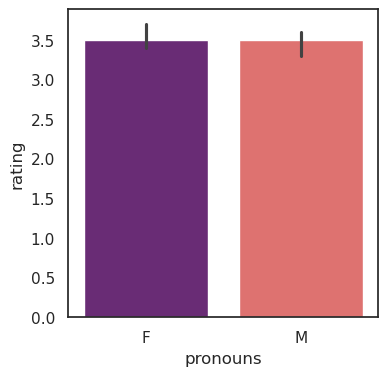

In [18]:
plt.figure(figsize=(4,4))
sns.barplot(data = df, x = 'pronouns', y = 'rating', estimator = 'median',
            palette = 'magma')
plt.show()

A boxplot overlaid with a stripplot will give us a better sense of the distribution of the data.

/tmp/ipykernel_832826/1838852018.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(df, x = 'pronouns', y = 'rating', palette = 'magma')


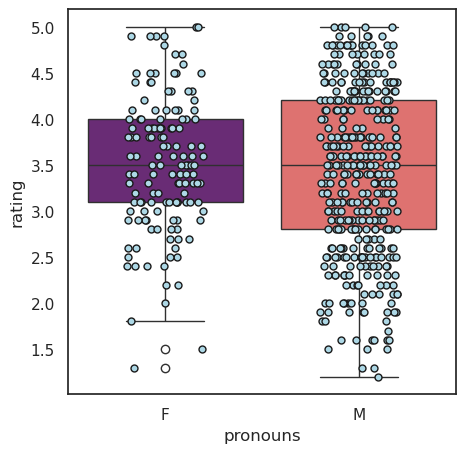

In [19]:
plt.figure(figsize=(5,5))
sns.boxplot(df, x = 'pronouns', y = 'rating', palette = 'magma')
sns.stripplot(data = df, x = 'pronouns', y = 'rating', jitter = 0.2, color = 'lightblue',
              edgecolor = 'k', linewidth=1)
plt.show()

## Task 3d. What are the most important words being used to describe professors in reviews?

Let's write a custom function that **tokenizes** and **lemmatizes** our list of words.
- **Word tokenization**: process of splitting text into individual words, called tokens. A common preprocessing step in natural language processing (NLP) so that text can be analyzed and processed more easily. Methods include whitespace tokenization, regular expression-based tokenization, and rule-based tokenization. We'll be using the `word_tokenize` tokenizer from `nltk`, with all its defaults.
- **Lemmatization**: process of reducing words to their base or dictionary form, called the lemma. Also a common pre-processing step in NLP, so that words with a common base form are treated the same way. For example, the lemma of "am" is "be", of "running" is "run", and of "mice" is "mouse".

In [109]:
PorterStemmer().stem("she\'s")

"she'"

In [95]:
word_tokenize('she\'s a girl')

['she', "'s", 'a', 'girl']

In [110]:
import string

In [113]:
def tokenize(text):
    tk = WhitespaceTokenizer()
    tokens = tk.tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item).strip(string.punctuation))
    return stems

Let's import a list of stop words, which are common English words that we will be ignoring in our analysis. `sklearn` provides a common list of stop words, and we can append additional words to this list. Below, we append pronouns, along with the words "class" and "student". Feel free to add any additional words you'd like to ignore to this list later on as you try to build upon this analysis!

In [174]:
my_stop_words = sktext.ENGLISH_STOP_WORDS.union(["he","she","his","her",
                                              "himself","herself", "hers","shes"
                                              "class","student", 'man', 'woman', 'girl',
                                                 'guy', 'lady', 'mr', 'mrs', 'ms'])
my_stop_words = my_stop_words.union([tokenize(word)[0] for word in my_stop_words])

For the purpose of analyzing review texts, we want to move from having one row for each professor to one row for each review. Lets do this with `.explode()` from pandas.

In [175]:
df_quality = df[(df['review'].apply(len) == df['quality'].apply(len))]
q = df_quality[['pronouns','review','quality']].explode(['review','quality'], ignore_index=True).dropna()
q['quality'] = q['quality'].astype(float)

In [176]:
q.head(5)

,pronouns,review,quality
0,F,Good experience for a class online. It was unc...,4.0
1,F,Honestly she didnt teach good at all and she w...,2.0
2,F,I think if you go by word for word in the modu...,1.0
3,F,Took her online class CSS64. We started buildi...,1.0
4,F,Took her for a late start hybrid class (Bus43)...,3.0


TFIDF vectorization is the process of assigning scores to each review in a document based on how frequently the word occurs, normalized by how frequently the word occurs in the dataset overall.

We'll use `TfidfVectorizer()` to generate these scores. This will return a matrix, with as many rows as reviews, and as many columns as words in our dataset.

In [177]:
vec = TfidfVectorizer(
    tokenizer = tokenize,
    stop_words = list(my_stop_words),
    ngram_range = (1,4)
)
X = vec.fit_transform(q.review)
feature_names = vec.get_feature_names_out()

/home/kantundpeterpan/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/kantundpeterpan/miniconda3/envs/nlp/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['anywh', 'becau', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh'] not in stop_words.
  warnings.warn(


In [178]:
feature_names.shape

(365516,)

In [191]:
np.random.choice(feature_names, size = 10)

array(["sense you'v", 'work easy week class',
       'technology(blackboard),noon lac know', 'just read quizz',
       "can't drop day", 'lot question understand materi', 'class ad',
       'languag pain', 'style rel scatter unorganized',
       "prof l'heureux help"], dtype=object)

`X` is a sparse matrix. We'll now move into filtering X for:
- Rows with male professors and reviews of high quality 
- Rows with female professors and reviews of high quality 
- Rows with male professors and reviews of low quality 
- Rows with female professors and reviews of low quality 

We can explore feature importance in each of these to get a sense of which words and phrases are coming up most often in the data.

In [192]:
m_pos = X[q.pronouns.eq('M') & q.quality.ge(4.5)]

In [193]:
m_pos = X[q.pronouns.eq('M') & q.quality.ge(4.5)]
f_pos = X[q.pronouns.eq('F') & q.quality.ge(4.5)]
m_neg = X[q.pronouns.eq('M') & q.quality.le(2.5)]
f_neg = X[q.pronouns.eq('F') & q.quality.le(2.5)]

In [194]:
np.unique(np.array(m_pos[0,:].todense()))

array([0.        , 0.04840186, 0.05048048, 0.05840671, 0.0588915 ,
       0.06440657, 0.07216968, 0.07743822, 0.08628339, 0.0890904 ,
       0.09454997, 0.09609708, 0.0982585 , 0.09872669, 0.10101388,
       0.10570444, 0.11337177, 0.12547472, 0.13281775, 0.13699447,
       0.146295  , 0.15107613, 0.15781475])

Let's have a look at what language students are using to describe male professors positively. The code below will return the 300 most important ngrams.

In [195]:
importance = np.argsort(np.asarray(m_pos.sum(axis = 0)))[0,::-1]
m_pos_features = feature_names[importance[:300]]

Print out the 25 most important features

In [196]:
m_pos_features[:25]

array(['comment', 'great', 'class', 'teacher', 'best', 'professor',
       'prof', 'good', 'help', 'realli', 'make', 'easi', 'love',
       'great teacher', 'awesom', 'know', 'learn', '', 'work', 'lot',
       'lectur', 'amaz', 'cours', 'nice', 'test'], dtype=object)

Let's have a look at what language students are using to describe female professors positively.

In [197]:
importance = np.argsort(np.asarray(f_pos.sum(axis = 0)))[0,::-1]
f_pos_features = feature_names[importance[:300]]
f_pos_features[:25]

array(['comment', 'great', 'class', 'teacher', 'prof', 'help',
       'professor', 'best', 'good', 'easi', 'realli', 'work', 'nice',
       'lot', 'love', 'make', 'learn', 'helpful', 'great teacher', '',
       'amaz', 'great prof', 'cours', 'lectur', 'hard'], dtype=object)

It should be interesting if there are words exclusively used for one gender

In [198]:
#male
only_m_pos = ~np.in1d(m_pos_features, f_pos_features)
m_pos_features[only_m_pos][:25]

/tmp/ipykernel_832826/3886134522.py:2: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  only_m_pos = ~np.in1d(m_pos_features, f_pos_features)


array(['fantast', 'excel teacher', 'topic', 'awesom professor',
       'excel professor', 'u', 'brilliant', 'realli enjoy', '2', 'old',
       'amaz professor', "professor i'v", "teacher i'v", 'mark', 'b',
       'hot', 'review', 'genuin', 'bore', "he'll", 'reason', 'hours',
       'want learn', 'overal', 'feel'], dtype=object)

In [199]:
#female
only_f_pos = ~np.isin(f_pos_features, m_pos_features)
f_pos_features[only_f_pos][:25]

array(['extra credit', 'especi', 'spanish', "she'll", 'assignments',
       'realli nice', 'offer', 'help prof', 'class nice', 'succeed',
       'realli want', 'alot', 'onlin class', 'knowledgable', 'group',
       'good lectur', 'attention', 'nice help', "i'd", 'real world',
       'easi grade', 'awsom', 'account', 'guid', 'semester'], dtype=object)

Let's have a look at what language students are using to describe male professors negatively.

In [200]:
importance = np.argsort(np.asarray(m_neg.sum(axis = 0)))[0,::-1]
m_neg_features = feature_names[importance[:300]]
m_neg_features[:25]

array(['comment', 'class', 'teach', 'hard', 'test', 'worst', 'professor',
       'teacher', 'lectur', '', 'time', 'know', 'like', 'grade', "don't",
       "doesn't", 'just', 'prof', 'avoid', 'bore', 'question', 'good',
       'make', 'doe', 'read'], dtype=object)

Let's have a look at what language students are using to describe female professors negatively.

In [201]:
importance = np.argsort(np.asarray(f_neg.sum(axis = 0)))[0,::-1]
f_neg_features = feature_names[importance[:300]]
f_neg_features[:25]

array(['comment', 'class', 'worst', 'grade', 'teacher', 'hard', 'teach',
       "don't", "doesn't", 'help', 'like', 'test', '', 'just', 'time',
       'work', 'professor', 'good', 'doe', 'question', 'make', 'know',
       'horribl', 'learn', 'unclear'], dtype=object)

Same analysis for exclusive words:

In [202]:
#male
only_m_neg = ~np.in1d(m_neg_features, f_neg_features)
m_neg_features[only_m_neg][:25]

/tmp/ipykernel_832826/728473888.py:2: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  only_m_neg = ~np.in1d(m_neg_features, f_neg_features)


array(['speak', 'hard understand', 'great', 'arrog', 'hear', 'costs',
       'smart', 'hardest', 'taught', 'listen', 'rambl', 'english',
       'exampl', 'let', 'sit', 'incred', 'wrote', 'knowledg', 'possible',
       'probabl', 'avoid costs', 'gpa', 'offic', '1', "can't teach"],
      dtype=object)

In [203]:
#female
only_f_neg = ~np.in1d(f_neg_features, m_neg_features)
f_neg_features[only_f_neg][:25]

/tmp/ipykernel_832826/1584707764.py:2: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  only_f_neg = ~np.in1d(f_neg_features, m_neg_features)


array(['late', 'disorgan', 'gave', 'advis', 'annoy', 'feedback', 'cost',
       'agre', 'helpful', 'disorganized', 'nice person', 'avoid cost',
       'unorganized', 'opinion', 'slow', 'quit', 'colleg', 'honestli',
       'fan', 'papers', 'spanish', 'easi class', 'favorites', 'instead',
       '5'], dtype=object)

## Congratulations on making it to the end! 
### Where to from here?
- We can feed these words into Ben Schmidt's [tool](https://benschmidt.org/profGender/#%7B%22database%22%3A%22RMP%22%2C%22plotType%22%3A%22pointchart%22%2C%22method%22%3A%22return_json%22%2C%22search_limits%22%3A%7B%22word%22%3A%5B%22his%20kids%22%2C%22her%20kids%22%5D%2C%22department__id%22%3A%7B%22%24lte%22%3A25%7D%7D%2C%22aesthetic%22%3A%7B%22x%22%3A%22WordsPerMillion%22%2C%22y%22%3A%22department%22%2C%22color%22%3A%22gender%22%7D%2C%22counttype%22%3A%5B%22WordCount%22%2C%22TotalWords%22%5D%2C%22groups%22%3A%5B%22unigram%22%5D%2C%22testGroup%22%3A%22C%22%7D) to derive insights by field.
- If you're interested in learning more about [web scraping](https://app.datacamp.com/learn/courses/web-scraping-with-python), take our courses on Web Scraping in Python
- If you're intersted in diving in to the world of Natural Language Processing, explore our [skill track](https://app.datacamp.com/learn/skill-tracks/natural-language-processing-in-python).

In [205]:
import os
from IPython.display import display, HTML

# List files and directories in the current directory
files = os.listdir('.')

# Create an HTML list to display the files
html = "<h1 style='background-color:salmon;text-indent: 1.2em;color:white'>\t Project extension</h1>"

# Display the HTML
display(HTML(html))


Unfortunately Ben Schmidt's tool does not seem to work anymore. So, in order to investigate gender bias in this dataset, I came up with the following research question:
Is the sentiment of the review associated with the use of stereotypical words for the two genders?

In order to answer that question, I looked for a lexicon that I could screen the reviews against. While I found some (a lot!) papers addressing detection of gender stereotypes using NLP, I could not find said lexicon - but I foudn that Language Models based on word embeddings also learn the gender bias implicit in the corpus they are trained on.

So I figured that maybe it would be possible to exploit that to construct - in a quick and dirty kind of fashion - this lexicon myself by asking Google's GEMINI. Some prompt engineering was necessary: [you can have a look for yourself]([url](https://g.co/gemini/share/db15535c30d9)). Ironically, Gemini seemed more hesitant to compile a list of words stereotypically negatively associated with women than for men.

Let's parse those lists:

In [218]:
def parse_gemini_list(s: str) -> list:
    """parse comma separated list of words remove annotations in parentheses"""
    new = [w.strip() for w in s.split(',')]
    for i,n in enumerate(new):
        if '(' in n:
            new[i] = n.split('(')[0]
    
    new = np.unique([x for word in new for x in tokenize(word)])
            
    return new

In [219]:
with open('w_pos_lex', 'r') as f:
    w_pos_lex = parse_gemini_list(f.read())

In [222]:
with open('w_neg_lex', 'r') as f:
    w_neg_lex = parse_gemini_list(f.read())

In [223]:
with open('m_pos_lex', 'r') as f:
    m_pos_lex = parse_gemini_list(f.read())

In [224]:
with open('m_neg_lex', 'r') as f:
    m_neg_lex = parse_gemini_list(f.read())

In [259]:
w_pos_lex_uni = w_pos_lex[~np.isin(w_pos_lex, m_pos_lex)]

In [264]:
m_pos_lex_uni = m_pos_lex[~np.isin(m_pos_lex, w_pos_lex)]

In [265]:
w_neg_lex_uni = w_neg_lex[~np.isin(w_neg_lex, m_neg_lex)]

In [266]:
m_neg_lex_uni = m_neg_lex[~np.isin(m_neg_lex, w_neg_lex)]

In [267]:
q.head(5)

,pronouns,review,quality
0,F,Good experience for a class online. It was unc...,4.0
1,F,Honestly she didnt teach good at all and she w...,2.0
2,F,I think if you go by word for word in the modu...,1.0
3,F,Took her online class CSS64. We started buildi...,1.0
4,F,Took her for a late start hybrid class (Bus43)...,3.0


In [390]:
stereo_count_w_pos = q.loc[q.pronouns.eq('F') & q.quality.ge(4.5)].review.apply(tokenize).apply(
    np.isin, args = (w_pos_lex_uni,)).apply(np.sum)

<Axes: xlabel='review'>

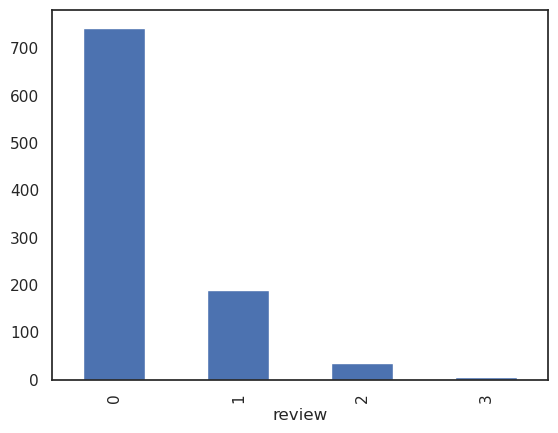

In [391]:
dist_w_pos = stereo_count_w_pos.value_counts()
dist_w_pos.plot(kind = 'bar')

In [392]:
stereo_count_m_pos = q.loc[q.pronouns.eq('M') & q.quality.ge(4.5)].review.apply(tokenize).apply(
    np.isin, args = (m_pos_lex_uni,)).apply(np.sum)

In [393]:
dist_m_pos = stereo_count_m_pos.value_counts()

<Axes: xlabel='review'>

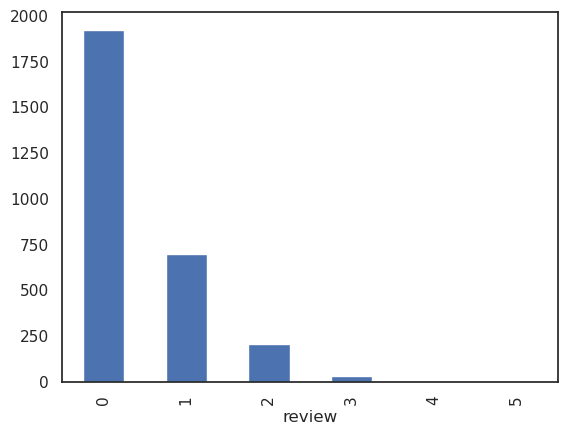

In [394]:
dist_m_pos.plot(kind = 'bar')

In [439]:
stereo_count_w_neg = q.loc[q.pronouns.eq('F') & q.quality.le(2.5)].review.apply(tokenize).apply(
    np.isin, args = (w_neg_lex_uni,)).apply(np.sum)

In [440]:
dist_w_neg = stereo_count_w_neg.value_counts().sort_index()

<Axes: xlabel='review'>

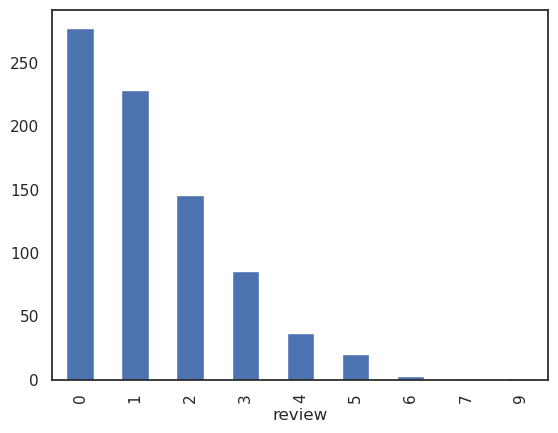

In [441]:
dist_w_neg.plot(kind = 'bar')

In [443]:
stereo_count_m_neg = q.loc[q.pronouns.eq('M') & q.quality.le(2.5)].review.apply(tokenize).apply(
    np.isin, args = (m_neg_lex_uni,)).apply(np.sum)

In [444]:
dist_m_neg = stereo_count_m_neg.value_counts()

<Axes: xlabel='review'>

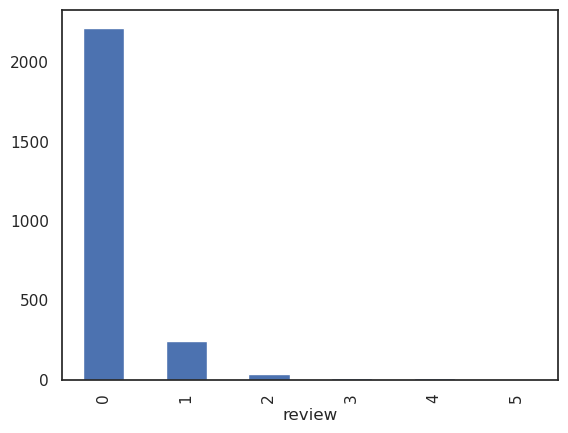

In [445]:
dist_m_neg.plot(kind = 'bar')

In [446]:
dist_m_neg

review
0    2218
1     240
2      37
3      10
4       9
5       1
Name: count, dtype: int64

In [447]:
from scipy.stats import chi2_contingency

In [448]:
table = np.zeros((2,  max(dist_w_neg.shape[0], dist_m_neg.shape[0])), dtype = int)
table[0, :dist_w_neg.shape[0]] = dist_w_neg.values
table[1, :dist_m_neg.shape[0]] = dist_m_neg.values

In [449]:
table

array([[ 278,  229,  146,   86,   37,   20,    3,    1,    1],
       [2218,  240,   37,   10,    9,    1,    0,    0,    0]])

In [450]:
chi2_table = pd.DataFrame(table, index = ['F', 'M'])

In [451]:
chi2_table

,0,1,2,3,4,5,6,7,8
F,278,229,146,86,37,20,3,1,1
M,2218,240,37,10,9,1,0,0,0


In [452]:
chi2_contingency(chi2_table)

Chi2ContingencyResult(statistic=np.float64(1073.2259818314606), pvalue=np.float64(2.3184709261716882e-226), dof=8, expected_freq=array([[6.02924005e+02, 1.13289807e+02, 4.42047648e+01, 2.31893848e+01,
        1.11115802e+01, 5.07267793e+00, 7.24668275e-01, 2.41556092e-01,
        2.41556092e-01],
       [1.89307600e+03, 3.55710193e+02, 1.38795235e+02, 7.28106152e+01,
        3.48884198e+01, 1.59273221e+01, 2.27533172e+00, 7.58443908e-01,
        7.58443908e-01]]))

In [453]:
table = np.zeros((2, max(dist_w_pos.shape[0], dist_m_pos.shape[0])), dtype = int)
table[0, :dist_w_pos.shape[0]] = dist_w_pos.values
table[1, :dist_m_pos.shape[0]] = dist_m_pos.values

In [454]:
chi2_table = pd.DataFrame(table, index = ['F', 'M'])

In [455]:
chi2_contingency(chi2_table)

Chi2ContingencyResult(statistic=np.float64(35.680653072523995), pvalue=np.float64(1.1002520334386392e-06), dof=5, expected_freq=array([[6.76990876e+02, 2.24479927e+02, 6.08759124e+01, 9.13138686e+00,
        1.26824818e+00, 2.53649635e-01],
       [1.99200912e+03, 6.60520073e+02, 1.79124088e+02, 2.68686131e+01,
        3.73175182e+00, 7.46350365e-01]]))